# Classifying Real and Deepfaked Presidential Voices Using Signal Processing and Machine Learning Techniques

# Problem Statement
Deepfake technology has recently become more accessible to normal people due to advances in AI.  This has prompted concern amongst political journalists that the technology could be abused to create false videos, resulting in an increase in misinformation.

In this project, I use machine learning algorithms and signal processing techniques to differentiate between real and deepfaked presidential voices.  This method can be used by journalists to ensure the veracity of the news they are reporting.  

## Data Collection
The real presidential voices were sourced from YouTube and the UVA Miller Center Presidential Speeches Archive.  The deepfaked voices were self-created using ElevenLabs or stripped from videos created by other people. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
import librosa
import librosa.display
import soundfile as sf
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score

# A) MFCC Approach 
## Mel Frequency Cepstral Coefficients Theory
The **Mel-frequency cepstrum** is used in signal processing to convert the frequency distribution of a sound signal, mimicking the way humans hear.  The coefficients that make up a MF cepstrum are commonly used for speech processing as they are scaled to the vocal and auditory systems of humans.
- Each coefficient represents how much of a speaker's vocal output lies within a given frequency range, as measured at various timeframes.
- The calculation of MFCCs contains many steps that are not practical to manually attempt under the time constraint of this project, so here the library Librosa is used for extraction.  

## 1. Creating DataFrames for each speaker with extracted components for all audio samples
- As source files, we have two sets of "speakers" - Donald Trump and Joe Biden.  Each set consists of the human and their respective deepfaked clone. There are four "speakers" in total.
- Four source folders are used, one for each speaker, containing unprocessed sample audio files.
- Four 'split' folders are used, one for each speaker, which will contain the sample audio files split into five-second clips.
- The audio files in each source folder are imported, split, and processed using the two below functions.
    - The function 'loadAndSplit' loads loads a soundfile from the source folder, splits it into five-second clips, and saves these audio clips to the 'split' folder for that speaker. 
    - The function 'readSplitFiles' gets a list of filenames in the 'split' folder for a speaker, loads each soundfile, and extracts the MFCC components for that soundfile.
- These processed MFCC lists are then turned into DataFrames representing voice information, one for each speaker.  A new column 'real' is added to the DataFrame, with a numerical value indicating which speaker the voice belongs to. 
- The four DataFrames are finally concatenated to create one DataFrame representing all audio information.

### Function: imports and splits an audio file
- The audio file is imported from a specified source folder and split into five second clips.
- These five second clips are then saved to a specified split folder. 

In [2]:
def loadAndSplit(fileName,filePath,destinationPath):
    y,sr=librosa.load(filePath+fileName)
    segment_length=sr*5
    num_segments = int(np.ceil(len(y) / segment_length))
    split=[]
    for i in range(num_segments):
        t = y[i * segment_length: (i + 1) * segment_length]
        split.append(t)
    for i in range(num_segments):
        fileNoMP3=fileName[:-4]
        sf.write(destinationPath+fileNoMP3+str(i)+".wav",split[i],sr)
    return "Done!"

### Function: imports and processes a folder of split audio files
- The file names for all audio files within the split folder are retrieved as a list.
- Each file from that list is imported and flattened.  
- The MFCCs features are obtained for each individual file.  This returns a two dimensional array of components against time for each file.  For each time snapshot, the mean is taken to convert the list of components into one number.
- This mean is appended to a list.  Each value in the list represents the average coefficient at that point in time for that sound file.  
- A list of lists is returned, which can be turned into a DataFrame giving sound information for that speaker.  

In [4]:
def readSplitFiles(trump_path):
    trump_file_names=os.listdir(trump_path)
    trump_samples=[]
    for trump_file in trump_file_names:
        y,sr=sf.read(trump_path+trump_file,always_2d=True)
        y=y.flatten('F')[:y.shape[0]]
        trump_mean=[np.mean(feature) for feature in librosa.feature.mfcc(y=y)]
        trump_samples.append(trump_mean)
    return trump_samples

### Creating strings with file paths
- These folders should be created by the user in the project directory, if they do not already exist.
- The source folders should be put in the respective speaker's 'Original_Files' directory.  The 'Split_Files' folders should be empty before running the code.

In [5]:
fakeTrumpOriginalPath="Trump_Fake_Original_Files/"
fakeTrumpSplitPath="Trump_Fake_Split_Files/"
realTrumpOriginalPath="Trump_Real_Original_Files/"
realTrumpSplitPath="Trump_Real_Split_Files/"
realBidenOriginalPath="Biden_Real_Original_Files/"
realBidenSplitPath="Biden_Real_Split_Files/"
fakeBidenOriginalPath="Biden_Fake_Original_Files/"
fakeBidenSplitPath="Biden_Fake_Split_Files/"

### Splitting audio files
- After running the below code, I manually removed a few samples that contained no what I considered no useful information, ex. applause at the end of a speech, five seconds containing only music.   
- I only removed 'useless' samples occuring at the very beginning or very end of the respective source audio, to avoid overly pruning the data.  
    - **For replication: names of removed split files**
        - Biden_2022_remarks290
        - Biden_2022_remarks291
        - Biden_2022_remarks292
        - Biden_2022_remarks293
        - Donald_Trump_Warzone0
        - Trump_statement_coronavirus114 
        - Fake_Biden_Dwarf_Fortress47
- Removing the 'useless' samples slightly increased the accuracy of KNN and DT and very slightly decreased the accuracy of logistic regression.  The overall impact was very small.

In [7]:
fakeTrumpFileNames=os.listdir(fakeTrumpOriginalPath)
for file in fakeTrumpFileNames:
    loadAndSplit(file,fakeTrumpOriginalPath,fakeTrumpSplitPath)
realTrumpFileNames=os.listdir(realTrumpOriginalPath)
for file in realTrumpFileNames:
    loadAndSplit(file,realTrumpOriginalPath,realTrumpSplitPath)
BidenFileNames=os.listdir(realBidenOriginalPath)
for file in BidenFileNames:
    loadAndSplit(file,realBidenOriginalPath,realBidenSplitPath)
BidenFileNames=os.listdir(fakeBidenOriginalPath)
for file in BidenFileNames:
    loadAndSplit(file,fakeBidenOriginalPath,fakeBidenSplitPath)

### Combining above functions to create dataframes for each speaker

In [6]:
fakeTrumpSamples=readSplitFiles(fakeTrumpSplitPath)
trumpFakeDF=pd.DataFrame(fakeTrumpSamples)
trumpFakeDF['real']=1
trumpFakeDF

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,real
0,-424.259697,93.156589,-6.920581,19.154209,15.988221,-0.787399,-13.063631,-21.683082,-19.802724,-6.213530,...,-5.200204,-17.417817,2.176303,-9.679389,-4.088780,-15.525971,-0.520351,-4.428511,-7.570618,1
1,-398.559072,73.850253,-4.873462,0.030463,2.206557,0.061731,-9.648070,-5.497289,-12.527162,-11.188401,...,-1.635505,-7.442033,-1.770412,-2.414234,3.549867,-7.515282,-2.775023,-5.110537,-4.963900,1
2,-337.311057,96.333586,-2.477364,19.183948,18.940092,0.293098,-21.301416,-12.621874,-16.556846,-17.330739,...,-5.431008,-8.625131,-2.253542,-4.165548,2.432244,-13.152199,-2.565163,-5.415470,-4.628859,1
3,-410.272678,53.793068,-2.928401,7.614284,5.963888,0.497777,-9.469813,-6.652520,-8.986611,-10.284806,...,-2.554161,-5.401740,-0.505427,-2.501852,0.707187,-9.186388,-0.494205,-5.140691,-5.502027,1
4,-399.954981,60.568172,-5.270010,14.784363,14.893934,-3.744468,-14.936250,-8.195150,-10.348047,-15.118112,...,-2.031648,-5.708888,-0.227956,-2.308603,2.491936,-8.689904,-1.334527,-5.148917,-4.632769,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,-444.759997,126.796554,-8.884345,6.572854,7.576124,2.740002,-18.877823,-13.344621,-19.897259,-20.196020,...,1.150942,-4.252723,5.688319,8.994552,2.267897,-13.707973,-0.315511,-12.991467,-8.016190,1
218,-432.024962,102.421739,2.398969,21.309982,8.410414,7.746678,-17.437498,-4.263827,-13.007488,-14.415209,...,1.841528,-7.411697,4.480478,6.403723,4.363841,-7.768232,-1.936202,-9.399785,-6.230112,1
219,-402.213880,116.561221,-4.565151,4.075878,8.673538,5.358191,-17.234240,-11.379982,-20.426697,-11.396798,...,1.344302,-4.660361,6.356215,9.416780,6.508837,-8.793467,-4.822983,-10.275964,-8.301618,1
220,-411.306260,101.334919,0.193434,18.377120,14.263207,6.479989,-21.989533,-7.149566,-15.979395,-14.574950,...,1.542894,-9.213760,6.482985,5.818041,4.141116,-9.127156,-3.973868,-11.615556,-7.682910,1


In [7]:
realTrumpSamples=readSplitFiles(realTrumpSplitPath)
trumpRealDF=pd.DataFrame(realTrumpSamples)
trumpRealDF['real']=0
trumpRealDF

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,real
0,-444.219890,86.144039,5.551438,22.393331,9.196142,13.188195,1.410202,5.641699,-1.933958,0.046114,...,2.286233,2.663391,1.355675,-1.264241,3.855920,-1.854355,0.156619,-3.632629,-0.017290,0
1,-323.132386,71.285788,-9.828436,25.611330,20.815322,5.221315,-7.010664,-2.736222,-9.321763,-6.898401,...,-8.773672,-3.943654,1.920970,0.063554,4.260677,-7.349281,0.236994,-4.598727,-4.753107,0
2,-325.300635,66.732073,-9.190044,17.909678,13.989146,4.746729,-11.802890,-5.692843,-8.966530,-17.628731,...,-8.077868,-5.390858,1.393692,-7.973947,5.213243,-9.563790,-0.406822,-2.332375,-6.750325,0
3,-414.648467,82.176761,2.423794,20.831631,10.621537,2.444225,-4.104136,-3.802737,-8.841777,-5.858686,...,-8.463674,-3.010797,1.680913,-2.385845,6.751542,-10.060344,-0.731914,-1.914133,-6.479436,0
4,-428.098858,91.823404,0.241136,17.918897,14.290229,8.880370,-1.644928,-2.756685,-3.536641,-3.614724,...,-3.802627,-4.398545,1.651633,-1.124227,4.771174,-5.475513,1.380109,-5.403966,-4.275431,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,-488.535269,107.519635,3.222199,23.236466,11.220634,1.767225,-14.720130,-0.024966,-2.488534,-3.470993,...,-1.239650,-2.719964,2.473878,2.975530,2.844486,-2.379797,0.603040,-5.643647,-7.576283,0
415,-505.145330,110.828151,6.799817,15.420562,10.063506,5.442996,-13.652246,-0.437862,-4.738819,-3.947152,...,1.624450,-2.468758,1.585135,4.547648,4.132538,-1.747571,-3.523974,-5.697359,-7.343091,0
416,-420.800554,135.277303,-8.123912,13.152458,10.359371,-8.677499,-22.038613,-2.965056,-8.385454,-13.577571,...,-4.109133,-7.544877,2.721197,2.688410,4.316717,-1.234689,-0.009081,-8.225122,-10.344576,0
417,-433.515096,119.554478,0.915437,5.898520,-4.457194,-3.851244,-12.524445,1.398815,-5.706632,-10.134508,...,-1.491269,-2.458456,2.048173,3.166978,7.306703,-2.791484,-2.552221,-4.335464,-11.807961,0


In [8]:
BidenSamples=readSplitFiles(realBidenSplitPath)
bidenRealDF=pd.DataFrame(BidenSamples)
bidenRealDF['real']=2
bidenRealDF

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,real
0,-544.995452,71.761516,-34.575414,12.871834,-7.799153,3.484118,-3.224424,-2.371332,-5.482417,3.751156,...,-6.156689,3.624597,-4.086861,-3.320211,0.127972,-7.454224,-0.480373,-7.051093,-2.220783,2
1,-508.683631,73.014815,-27.670748,27.022024,-5.333847,8.605062,-7.496513,-3.856099,-5.316690,-2.158494,...,-7.256074,-0.739030,-9.574744,-2.228869,-0.909834,-7.867456,-0.926167,-5.499832,-3.592673,2
2,-451.757995,75.579118,-25.062863,16.696324,-5.241645,-6.134395,-7.236600,-9.333073,-14.417403,-3.071932,...,-8.338831,-2.094480,-8.580087,-6.004986,0.365879,-13.306355,-2.305090,-9.266536,-6.569687,2
3,-402.648200,85.138631,-53.678857,11.438876,-18.395506,-2.948393,-21.911288,-6.776433,-7.809047,-1.095563,...,-6.627325,-0.948297,-8.321536,-6.676230,-2.511989,-12.495499,-2.115788,-6.866489,-8.376197,2
4,-354.134439,73.706757,-77.288262,11.925952,-12.805300,1.577253,-24.014024,-6.608038,-8.408714,-3.180707,...,-8.202684,-3.278394,-8.587782,-8.061217,-0.067786,-9.918885,-1.716826,-6.078955,-7.721342,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,-452.196540,82.494358,-31.401569,19.002231,-2.852093,3.014084,-16.542034,-7.856664,-13.098485,-7.076170,...,-11.324953,-0.448457,-8.841020,-4.413341,-1.323429,-11.120537,-1.272653,-7.923129,-5.645467,2
286,-524.346545,91.584578,-28.708741,-4.953845,-6.310487,-6.885598,-8.815044,-3.022827,-2.669745,3.582656,...,-5.345798,0.378864,-10.256782,-3.949231,0.709134,-11.731741,1.770486,-2.983883,-4.737377,2
287,-469.371213,90.892653,-41.478159,12.167601,0.674631,-3.585964,-11.809576,-7.272098,-8.934254,0.294347,...,-9.872513,-0.148720,-9.204213,-6.169591,-1.772695,-12.714992,0.401410,-6.944002,-4.561339,2
288,-444.194214,100.904476,-51.629633,-3.245704,-6.031328,-3.654695,-10.964239,-14.486266,-10.723370,8.894269,...,-10.088887,-1.357709,-12.164780,-8.750073,2.859072,-15.855382,1.775971,-4.973306,-2.833676,2


In [9]:
BidenSamples=readSplitFiles(fakeBidenSplitPath)
bidenFakeDF=pd.DataFrame(BidenSamples)
bidenFakeDF['real']=3
bidenFakeDF

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,real
0,-125.940425,133.807266,-16.262490,29.418933,6.520943,-2.592707,-11.412995,-10.290717,-15.574124,1.682491,...,-1.161505,-3.476313,-7.946430,-7.607088,-4.475476,-13.772212,-3.560642,-4.614921,-4.107599,3
1,-93.547034,126.326665,-16.731672,41.500382,13.413346,2.048705,-8.993237,-5.438092,-9.006029,0.597655,...,2.047250,-3.370391,-3.724161,-1.764454,-0.825604,-10.565737,0.144833,-2.414615,-1.310225,3
2,-88.565503,144.777642,-17.275649,40.040442,17.602825,6.910430,-7.408216,-1.820005,-2.614302,4.684694,...,8.521696,-2.574003,-7.120316,-0.839733,1.918886,-8.335930,-1.708725,-1.315013,-1.568241,3
3,-90.137311,145.659453,-11.583174,39.984279,15.927435,7.159089,-2.996673,2.547048,-7.784417,-0.238701,...,5.756107,-0.895620,-1.745727,-0.444692,1.623243,-6.803785,-1.178124,-3.747873,-3.509768,3
4,-92.132887,133.487035,-10.049476,46.042954,21.489646,7.662293,-6.084682,0.026707,-2.505019,0.389939,...,3.445750,-4.685469,-3.138714,1.745231,1.737562,-7.119405,0.901884,-2.924758,-2.979924,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,-448.999590,103.801431,-65.705748,17.159278,-24.868881,1.297766,-14.995301,-18.592529,-6.049441,1.885795,...,-4.460488,3.523098,-22.974655,-1.566946,-4.170852,-16.148414,-4.811368,-3.270579,2.436687,3
134,-463.222562,101.877793,-68.521628,20.634123,-17.573624,-1.944242,-27.199159,-19.590064,0.034306,3.028609,...,-5.447268,5.742520,-22.631350,-4.426237,-5.240553,-17.187814,-3.050028,-3.534410,0.694125,3
135,-438.582597,112.217194,-67.277878,21.255286,-18.264874,-7.020130,-32.224805,-24.007941,1.513961,3.987080,...,-6.440782,5.075116,-23.832272,-4.638424,-6.041974,-16.250646,-2.373572,-8.201218,1.056603,3
136,-453.407030,100.721532,-69.376328,34.155388,-20.804081,1.013737,-32.192890,-19.435938,-0.898865,0.933590,...,-7.211802,6.009881,-24.239895,0.053354,-1.622502,-17.075846,-2.540040,-5.578362,0.445332,3


### Visualizing original and processed files
- The first graph shows the time series of the original audio sample.
- The second graph shows the audio sample represented as a spectrogram (graph of sound frequencies) after conversion to the Mel frequency cepstrum.
- The third graph shows the MFC coefficients, which are used here for analysis. 

Text(0.5, 1.0, 'MFCCs')

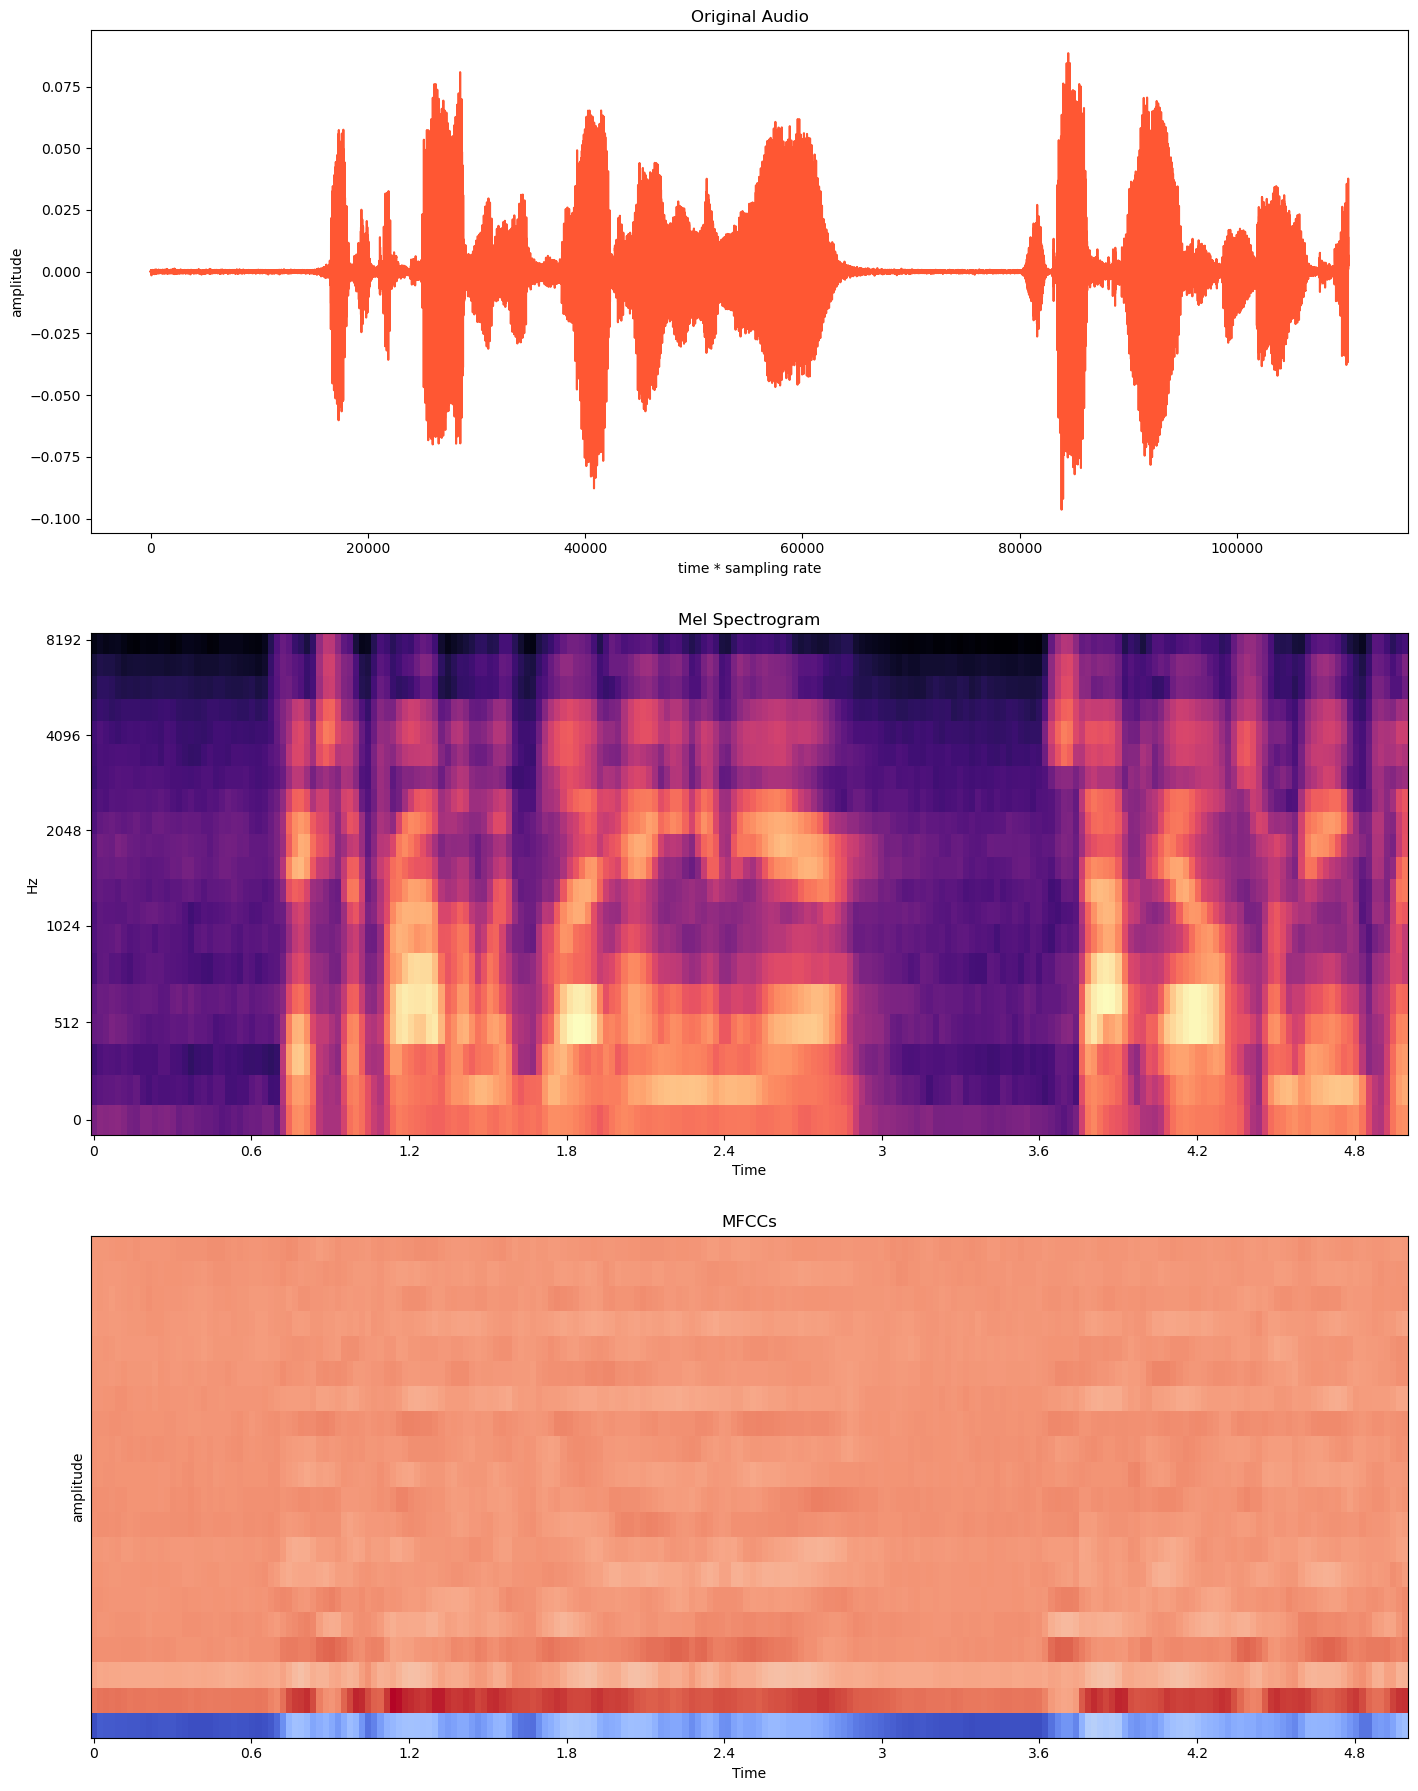

In [10]:
y,sr=librosa.load('_Soundfiles_For_Visualization/Fake_Biden_Dwarf_Fortress10.wav')
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
plt.figure(figsize=(17, 30))
plt.subplot(4,1,1)
xmin=0
fig_1=plt.plot(y,'#FF5733')
plt.title('Original Audio')
plt.xlabel('time * sampling rate')
plt.ylabel('amplitude') 

plt.subplot(4,1,2)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=20,fmax=8000)
fig_2 = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000)
plt.title('Mel Spectrogram')
plt.subplot(4,1,3)
fig_3 = librosa.display.specshow(mfccs, x_axis='time')
plt.ylabel('amplitude')
plt.title('MFCCs')

### Merging all samples to one DataFrame

In [12]:
df2 = pd.concat([trumpRealDF, trumpFakeDF, bidenRealDF,bidenFakeDF], axis=0)
df2.columns = df2.columns.astype(str)
df2

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,real
0,-444.219890,86.144039,5.551438,22.393331,9.196142,13.188195,1.410202,5.641699,-1.933958,0.046114,...,2.286233,2.663391,1.355675,-1.264241,3.855920,-1.854355,0.156619,-3.632629,-0.017290,0
1,-323.132386,71.285788,-9.828436,25.611330,20.815322,5.221315,-7.010664,-2.736222,-9.321763,-6.898401,...,-8.773672,-3.943654,1.920970,0.063554,4.260677,-7.349281,0.236994,-4.598727,-4.753107,0
2,-325.300635,66.732073,-9.190044,17.909678,13.989146,4.746729,-11.802890,-5.692843,-8.966530,-17.628731,...,-8.077868,-5.390858,1.393692,-7.973947,5.213243,-9.563790,-0.406822,-2.332375,-6.750325,0
3,-414.648467,82.176761,2.423794,20.831631,10.621537,2.444225,-4.104136,-3.802737,-8.841777,-5.858686,...,-8.463674,-3.010797,1.680913,-2.385845,6.751542,-10.060344,-0.731914,-1.914133,-6.479436,0
4,-428.098858,91.823404,0.241136,17.918897,14.290229,8.880370,-1.644928,-2.756685,-3.536641,-3.614724,...,-3.802627,-4.398545,1.651633,-1.124227,4.771174,-5.475513,1.380109,-5.403966,-4.275431,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,-448.999590,103.801431,-65.705748,17.159278,-24.868881,1.297766,-14.995301,-18.592529,-6.049441,1.885795,...,-4.460488,3.523098,-22.974655,-1.566946,-4.170852,-16.148414,-4.811368,-3.270579,2.436687,3
134,-463.222562,101.877793,-68.521628,20.634123,-17.573624,-1.944242,-27.199159,-19.590064,0.034306,3.028609,...,-5.447268,5.742520,-22.631350,-4.426237,-5.240553,-17.187814,-3.050028,-3.534410,0.694125,3
135,-438.582597,112.217194,-67.277878,21.255286,-18.264874,-7.020130,-32.224805,-24.007941,1.513961,3.987080,...,-6.440782,5.075116,-23.832272,-4.638424,-6.041974,-16.250646,-2.373572,-8.201218,1.056603,3
136,-453.407030,100.721532,-69.376328,34.155388,-20.804081,1.013737,-32.192890,-19.435938,-0.898865,0.933590,...,-7.211802,6.009881,-24.239895,0.053354,-1.622502,-17.075846,-2.540040,-5.578362,0.445332,3


## 2. Analyzing samples

### Logistic regression:

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report,confusion_matrix, f1_score
import statsmodels.api as sm

In [21]:
# creating test and train data
X=df2.drop('real',axis=1)
X=sm.tools.add_constant(X)
y=df2['real']
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)

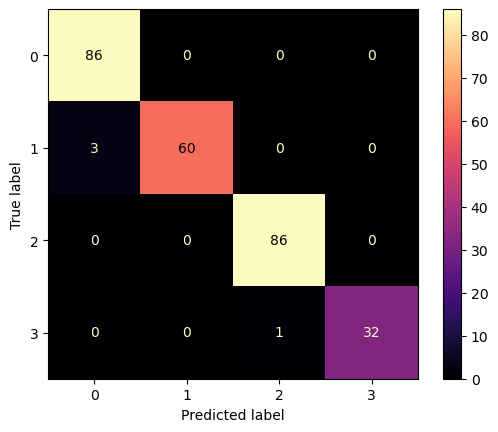

In [22]:
# setting up pipeline
numeric_columns=X.columns.tolist()
numeric_pipeline=Pipeline([('numscaler',MinMaxScaler())])
ct=ColumnTransformer([('numpipe',numeric_pipeline,numeric_columns)])
log_pipe=Pipeline([('preprocess',ct),
                   ('model',LogisticRegression(multi_class='auto',
                                               solver='lbfgs',
                                               fit_intercept=False))])
# fitting and predicting
log_pipe.fit(X_train,y_train)
y_pred = log_pipe.predict(X_test)
y_pred_prob=log_pipe.predict_proba(X_test)
# creating and displaying confusion matrix
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp=disp.plot(include_values=True, cmap='magma', ax=None, 
               xticks_rotation='horizontal')
plt.grid(False)
plt.show()

In [23]:
# creating and displaying classification report
clf_report=classification_report(y_test,y_pred,output_dict=True)
#print(f1_score(y_test,y_pred, average='weighted'))
print(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))
pd.DataFrame(clf_report)

0.9992159759318012


,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.966292,1.000000,0.988506,1.000000,0.985075,0.988699,0.985495
recall,1.000000,0.952381,1.000000,0.969697,0.985075,0.980519,0.985075
f1-score,0.982857,0.975610,0.994220,0.984615,0.985075,0.984325,0.985016
support,86.000000,63.000000,86.000000,33.000000,0.985075,268.000000,268.000000


### K-nearest neighbors:

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

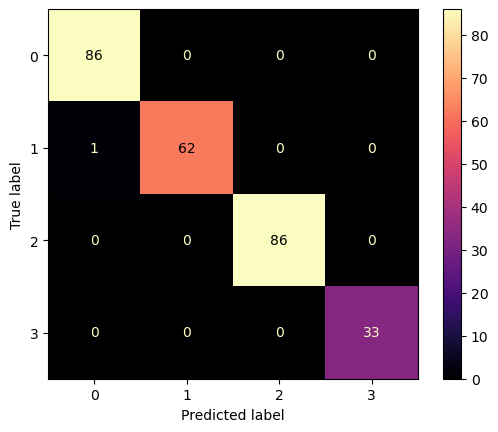

In [25]:
# setting up pipeline
numeric_columns=X.columns.tolist()
numeric_pipeline=Pipeline([('numscaler',MinMaxScaler())])
ct=ColumnTransformer([('numpipe',numeric_pipeline,numeric_columns)])
knn_pipe=Pipeline([('preprocess',ct),
                   ('model',KNeighborsClassifier())])
# setting up gridsearch 
grid_params = {'model__n_neighbors': [3, 5, 7, 9, 11, 15],
               'model__weights': ['uniform', 'distance'],
               'model__metric': ['euclidean', 'manhattan']}
grid = GridSearchCV(estimator=knn_pipe, param_grid=grid_params, 
                    cv=5, n_jobs=-1)
# fitting and predicting
grid.fit(X_train, y_train)
y_pred=grid.predict(X_test)
y_pred_prob=grid.predict_proba(X_test)
# creating and displaying confusion matrix
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp=disp.plot(include_values=True, cmap='magma', ax=None, 
               xticks_rotation='horizontal')
plt.grid(False)
plt.show()

In [26]:
# creating and displaying classification report
clf_report=classification_report(y_test,y_pred,output_dict=True)
print(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))
pd.DataFrame(clf_report)

1.0


,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.988506,1.000000,1.0,1.0,0.996269,0.997126,0.996312
recall,1.000000,0.984127,1.0,1.0,0.996269,0.996032,0.996269
f1-score,0.994220,0.992000,1.0,1.0,0.996269,0.996555,0.996265
support,86.000000,63.000000,86.0,33.0,0.996269,268.000000,268.000000


### Decision tree:

In [27]:
from sklearn.tree import DecisionTreeClassifier

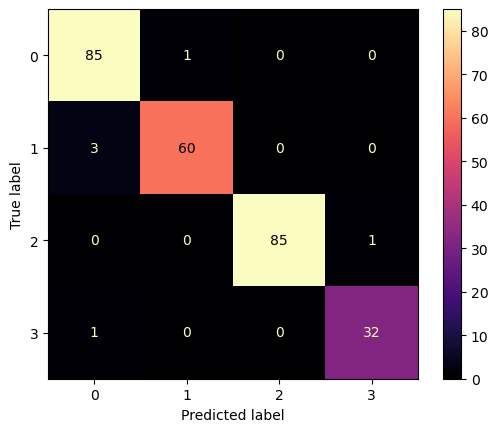

In [28]:
numeric_pipeline=Pipeline([('numscaler',MinMaxScaler())])
ct=ColumnTransformer([('numpipe',numeric_pipeline,numeric_columns)])
tree_pipe=Pipeline([('preprocess',ct),
                    ('tree',DecisionTreeClassifier(criterion = 'gini', random_state=42))])
# fitting and predicting
parameters=dict(tree__criterion=['gini', 'entropy'],
                tree__max_depth = [2,4,6,8,10,12])
grid=GridSearchCV(estimator=tree_pipe,param_grid=parameters,
                 cv=5, n_jobs=-1)
grid.fit(X_train,y_train)
y_pred = grid.predict(X_test)
y_pred_prob=grid.predict_proba(X_test)
# creating and displaying confusion matrix
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp=disp.plot(include_values=True, cmap='magma', ax=None, 
               xticks_rotation='horizontal')
plt.grid(False)
plt.show()

In [30]:
# creating and displaying classification report
clf_report=classification_report(y_test,y_pred,output_dict=True)
print(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))
pd.DataFrame(clf_report)

0.9834638397771234


,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.955056,0.983607,1.000000,0.969697,0.977612,0.977090,0.977993
recall,0.988372,0.952381,0.988372,0.969697,0.977612,0.974706,0.977612
f1-score,0.971429,0.967742,0.994152,0.969697,0.977612,0.975755,0.977641
support,86.000000,63.000000,86.000000,33.000000,0.977612,268.000000,268.000000


# B) LPC (Linear Predictive Coding) Approach 
## Linear Predictive Coding Theory
**Linear predictive coding** is a signal processing method designed for speech transmission and compression. It is used to numerically approximate the sound of the human voice - instead of attempting to transmit an entire sound signal, communication systems will transmit only the *linear predictive coefficients*.
- Human speech is modeled as two components:
    - The 'source' or initial sound produced by the body, and
    - The 'filter' or change in this sound produced by resonance in the vocal tract.  

The intention behind LPC is to model the human voice by separating the source components of human speech from the filter or resonance components. It can also calculate an 'error' component containing noise.  It does this by using a technique called **autoregression**.
   - Autoregression is used to process signals in which there is a correlation between sample values of the signal and delayed values of the same signals. It can be used when a signal contains repeating patterns that contribute to its overall values, in this case, the resonance component of speech.

Below I use a technique called Levinson-Durbin recursion to return the linear predictive coefficients *a* for a given signal.  These coefficients will be used to numerically represent the filter components of the human voice.  The Levinson-Durbin recursion can also return a prediction error *e* and reflection/resonance coefficients *k*, but here these are not used. 

## 1. Creating DataFrames for each speaker with extracted components for all samples
- This process is essentially the same as above.  
    - A function called 'levinson_durbin' is created to extract the LPC components from a sound sample.
    - The 'readSplitFiles' function is modified to extract the LPC components for each read five-second sample, instead of the MFCC components.  
    - These LPC components are appended as a list to a list representing all vocal information for that speaker across all samples. 

In [31]:
def levinson_durbin(y, m): 
# source signal y, number of desired components m
# returns LPC components for the source signal as a
    R=[y.dot(y)]
    for i in range(1, m+1):
        Ri = y[i:].dot(y[:-i])
        R.append(Ri)
    R=np.asarray(R)
    a = np.array([1, -R[1] / R[0]])
    E = R[0] + R[1] * a[1]
    for j in range(1, i):
        if (E==0):
            E=10**-10
        alpha = - a[:j+1].dot(R[j+1:0:-1]) / E
        a = np.hstack([a,0])
        a = a + alpha * a[::-1]
        E *= (1 - alpha**2)
    return a

In [32]:
def readSplitFilesLPC(trump_path):
    trump_file_names=os.listdir(trump_path)
    trump_samples=[]
    for trump_file in trump_file_names:
        y,sr=sf.read(trump_path+trump_file,always_2d=True)
        y=y.flatten('F')[:y.shape[0]]
        trump_LPC=levinson_durbin(y,20)
        trump_samples.append(trump_LPC)
    return trump_samples

### Combining above functions to create dataframes for each speaker

In [33]:
fakeTrumpSamples=readSplitFilesLPC(fakeTrumpSplitPath)
fakeTrumpDF=pd.DataFrame(fakeTrumpSamples)
fakeTrumpDF['real']=0
fakeTrumpDF

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,real
0,1.0,-1.581716,1.338079,-1.313327,1.277556,-1.566972,1.939798,-1.783661,1.523316,-1.378956,...,1.204203,-0.904331,0.720927,-0.554153,0.521102,-0.420478,0.226621,-0.065245,0.055419,0
1,1.0,-1.959485,1.364274,-0.685158,0.565339,-0.433565,0.709957,-1.125558,1.054884,-0.891117,...,0.298690,-0.285776,0.324321,-0.349707,0.287196,-0.245023,0.181759,-0.047993,0.015366,0
2,1.0,-1.539784,0.959145,-0.735884,0.596394,-0.289955,0.495409,-0.858075,0.839436,-0.937191,...,0.403232,-0.250603,0.262548,-0.356675,0.355021,-0.330497,0.315895,-0.121455,0.021582,0
3,1.0,-1.370530,0.755308,-0.832871,0.729146,-0.358454,0.592838,-0.811219,0.720029,-0.783955,...,0.397507,-0.304656,0.257629,-0.304204,0.291268,-0.267121,0.205026,-0.034930,0.023831,0
4,1.0,-1.700083,0.976097,-0.429145,0.439174,-0.308829,0.530039,-1.005275,0.851259,-0.737644,...,0.231952,-0.275643,0.308461,-0.342682,0.353729,-0.257878,0.256216,-0.152471,0.042532,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,1.0,-1.890616,1.374075,-0.783149,0.572721,-0.498096,0.606664,-0.658145,0.683680,-0.726413,...,0.560992,-0.455262,0.457841,-0.538000,0.345395,-0.227232,0.281081,-0.179467,0.063289,0
218,1.0,-1.561132,1.300063,-1.292170,1.156502,-1.174447,1.162571,-1.139741,1.249652,-1.197145,...,0.991689,-0.866145,0.727813,-0.593857,0.456102,-0.379032,0.278356,-0.194372,0.138141,0
219,1.0,-1.343293,0.850654,-0.963194,0.955652,-0.954493,0.838202,-0.772893,1.071566,-0.860561,...,0.664907,-0.629098,0.572709,-0.449119,0.447960,-0.254135,0.263247,-0.258752,0.122552,0
220,1.0,-1.268862,0.861340,-0.906900,0.742707,-0.707072,0.618146,-0.543573,0.648280,-0.661290,...,0.564835,-0.406531,0.402558,-0.328540,0.238536,-0.198621,0.191976,-0.170989,0.130715,0


In [34]:
realTrumpSamples=readSplitFilesLPC(realTrumpSplitPath)
realTrumpDF=pd.DataFrame(realTrumpSamples)
realTrumpDF['real']=1
realTrumpDF

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,real
0,1.0,-1.462473,0.564645,-0.166819,0.234078,-0.105471,0.243328,-0.553614,0.454642,-0.146754,...,0.231442,-0.202941,0.263407,-0.186880,0.154396,-0.295878,0.308526,-0.098418,0.026037,1
1,1.0,-1.335289,0.637207,-0.411074,0.286781,-0.029602,0.161807,-0.487194,0.508751,-0.421582,...,0.212096,-0.222030,0.308872,-0.242193,0.189869,-0.318549,0.323873,-0.125873,0.085432,1
2,1.0,-1.298426,0.545944,-0.293049,0.026858,0.170927,0.233215,-0.579267,0.490646,-0.364439,...,0.176873,-0.221604,0.210013,-0.121898,0.218999,-0.335605,0.205401,-0.137406,0.139650,1
3,1.0,-1.277805,0.417884,-0.181073,0.151802,-0.116040,0.375725,-0.559026,0.439860,-0.221425,...,0.235063,-0.205174,0.233446,-0.129725,0.105741,-0.261151,0.246371,-0.065548,0.047791,1
4,1.0,-1.493168,0.612596,-0.172794,0.258212,-0.125539,0.186235,-0.540897,0.621859,-0.441695,...,0.205414,-0.163679,0.280441,-0.302139,0.185387,-0.236496,0.293452,-0.079608,-0.009681,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,1.0,-2.083907,2.182566,-1.988120,1.676900,-1.258096,0.984298,-0.930413,0.998690,-1.064572,...,0.861936,-0.695902,0.588373,-0.424542,0.277076,-0.284378,0.244055,-0.056369,-0.002965,1
415,1.0,-1.996865,1.830614,-1.609954,1.405625,-1.027526,0.954756,-0.893346,0.775371,-0.868108,...,0.941301,-0.871209,0.731481,-0.597328,0.386547,-0.287100,0.205310,0.007228,-0.036889,1
416,1.0,-2.309821,1.996709,-0.949905,0.740017,-0.768228,0.598377,-0.663915,0.669261,-0.541709,...,0.642740,-0.445532,0.496460,-0.588170,0.494025,-0.448305,0.581687,-0.475758,0.160721,1
417,1.0,-2.244422,2.096678,-1.529413,1.365758,-1.112254,0.911327,-0.920855,0.865818,-0.743362,...,0.683574,-0.606940,0.694012,-0.644210,0.390490,-0.382108,0.451743,-0.223245,0.021603,1


In [35]:
realBidenSamples=readSplitFilesLPC(realBidenSplitPath)
realBidenDF=pd.DataFrame(realBidenSamples)
realBidenDF['real']=2
realBidenDF

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,real
0,1.0,-2.195531,1.794796,-0.884114,0.950257,-1.227861,0.886181,-0.761406,1.331192,-1.301449,...,0.932876,-0.771870,0.620756,-0.727859,0.751174,-0.454155,0.296355,-0.318764,0.161119,2
1,1.0,-1.797312,1.593871,-1.169097,0.708194,-0.514756,0.444008,-0.454832,0.580786,-0.553824,...,0.385390,-0.417407,0.566502,-0.638600,0.652347,-0.536935,0.360578,-0.236340,0.153762,2
2,1.0,-2.211084,2.408089,-1.931471,1.330792,-0.869505,0.725690,-0.935756,1.051636,-0.905296,...,0.650258,-0.597016,0.680045,-0.762248,0.728342,-0.577753,0.346447,-0.138132,0.059366,2
3,1.0,-2.449018,2.919574,-2.698756,2.305782,-1.874172,1.680945,-1.837610,2.090264,-2.076603,...,1.160037,-0.938908,0.882596,-0.855222,0.756348,-0.583923,0.413513,-0.220942,0.052643,2
4,1.0,-2.326661,2.748183,-2.526650,2.016282,-1.362207,1.079958,-1.230422,1.434010,-1.498554,...,1.148860,-0.998663,0.989496,-0.924876,0.806787,-0.649568,0.460988,-0.246079,0.097190,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,1.0,-2.410538,3.005168,-2.980677,2.380588,-1.384757,0.785323,-0.806698,1.029134,-1.142800,...,0.573848,-0.380738,0.488046,-0.619337,0.666512,-0.624769,0.467425,-0.256491,0.103379,2
286,1.0,-2.613307,2.825527,-1.930336,1.268289,-0.926352,0.884582,-1.157597,1.355734,-0.962362,...,0.817206,-0.772887,0.700734,-0.837419,0.690149,-0.433613,0.400401,-0.298465,0.089576,2
287,1.0,-2.544065,3.148384,-2.906111,2.345696,-1.734577,1.470396,-1.618532,1.940389,-1.978708,...,1.115143,-0.860533,0.876837,-0.961056,0.909147,-0.711942,0.441701,-0.199544,0.057137,2
288,1.0,-2.489566,2.764429,-2.184397,1.681915,-1.319371,1.244423,-1.435054,1.598079,-1.363963,...,0.884885,-0.685653,0.747198,-0.902001,0.840689,-0.655845,0.485595,-0.277017,0.086138,2


In [36]:
fakeBidenSamples=readSplitFilesLPC(fakeBidenSplitPath)
fakeBidenDF=pd.DataFrame(fakeBidenSamples)
fakeBidenDF['real']=3
fakeBidenDF

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,real
0,1.0,-1.850606,1.500756,-1.109965,0.974358,-0.778196,0.507754,-0.443191,0.601208,-0.625960,...,0.562921,-0.444548,0.421048,-0.423325,0.420978,-0.352180,0.255601,-0.164629,0.075455,3
1,1.0,-1.673255,1.382732,-1.107923,0.857820,-0.783385,0.669390,-0.577815,0.609879,-0.723402,...,0.553236,-0.429107,0.435424,-0.459796,0.433200,-0.354922,0.269856,-0.172440,0.075504,3
2,1.0,-1.768044,1.393378,-0.957763,0.655541,-0.501757,0.367649,-0.317790,0.451295,-0.680313,...,0.484920,-0.329534,0.353968,-0.429975,0.415948,-0.431519,0.369649,-0.193657,0.065586,3
3,1.0,-1.835969,1.445323,-1.085434,0.939197,-0.745246,0.453862,-0.178736,0.065785,-0.166465,...,0.540564,-0.472633,0.462446,-0.496613,0.473765,-0.360926,0.191909,-0.082561,0.036606,3
4,1.0,-1.570619,1.137121,-0.847815,0.572355,-0.466606,0.453540,-0.357458,0.281986,-0.470759,...,0.513870,-0.407774,0.383293,-0.429534,0.379175,-0.274037,0.181691,-0.065750,0.037381,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,1.0,-3.261176,5.708996,-7.314173,7.244953,-5.246054,2.140653,0.823630,-2.322017,2.031852,...,1.148236,-0.894716,0.228570,0.320564,-0.521987,0.428070,-0.254353,0.131522,-0.025992,3
134,1.0,-3.507110,6.565544,-8.841901,9.258097,-7.532065,4.546927,-1.634244,0.090085,-0.288933,...,3.024818,-2.602541,1.781213,-1.008346,0.460106,-0.121538,-0.070469,0.118512,-0.041083,3
135,1.0,-3.325058,5.670739,-6.801020,6.268592,-4.208217,1.582952,0.440456,-1.021135,0.330038,...,0.995290,-0.514520,0.036115,0.080742,0.026991,-0.084685,0.028327,0.046605,-0.023117,3
136,1.0,-3.202941,5.528640,-6.890757,6.656241,-4.841817,2.314102,-0.108450,-0.916024,0.697237,...,1.065331,-0.865688,0.563119,-0.413101,0.371403,-0.292934,0.161450,-0.051937,0.033579,3


### Visualizing original and processed files
- The first graph shows the time series of the original audio sample.
- The second graph shows the LPC coefficients of that time series, which are used here for analysis. 

Text(0, 0.5, 'amplitude')

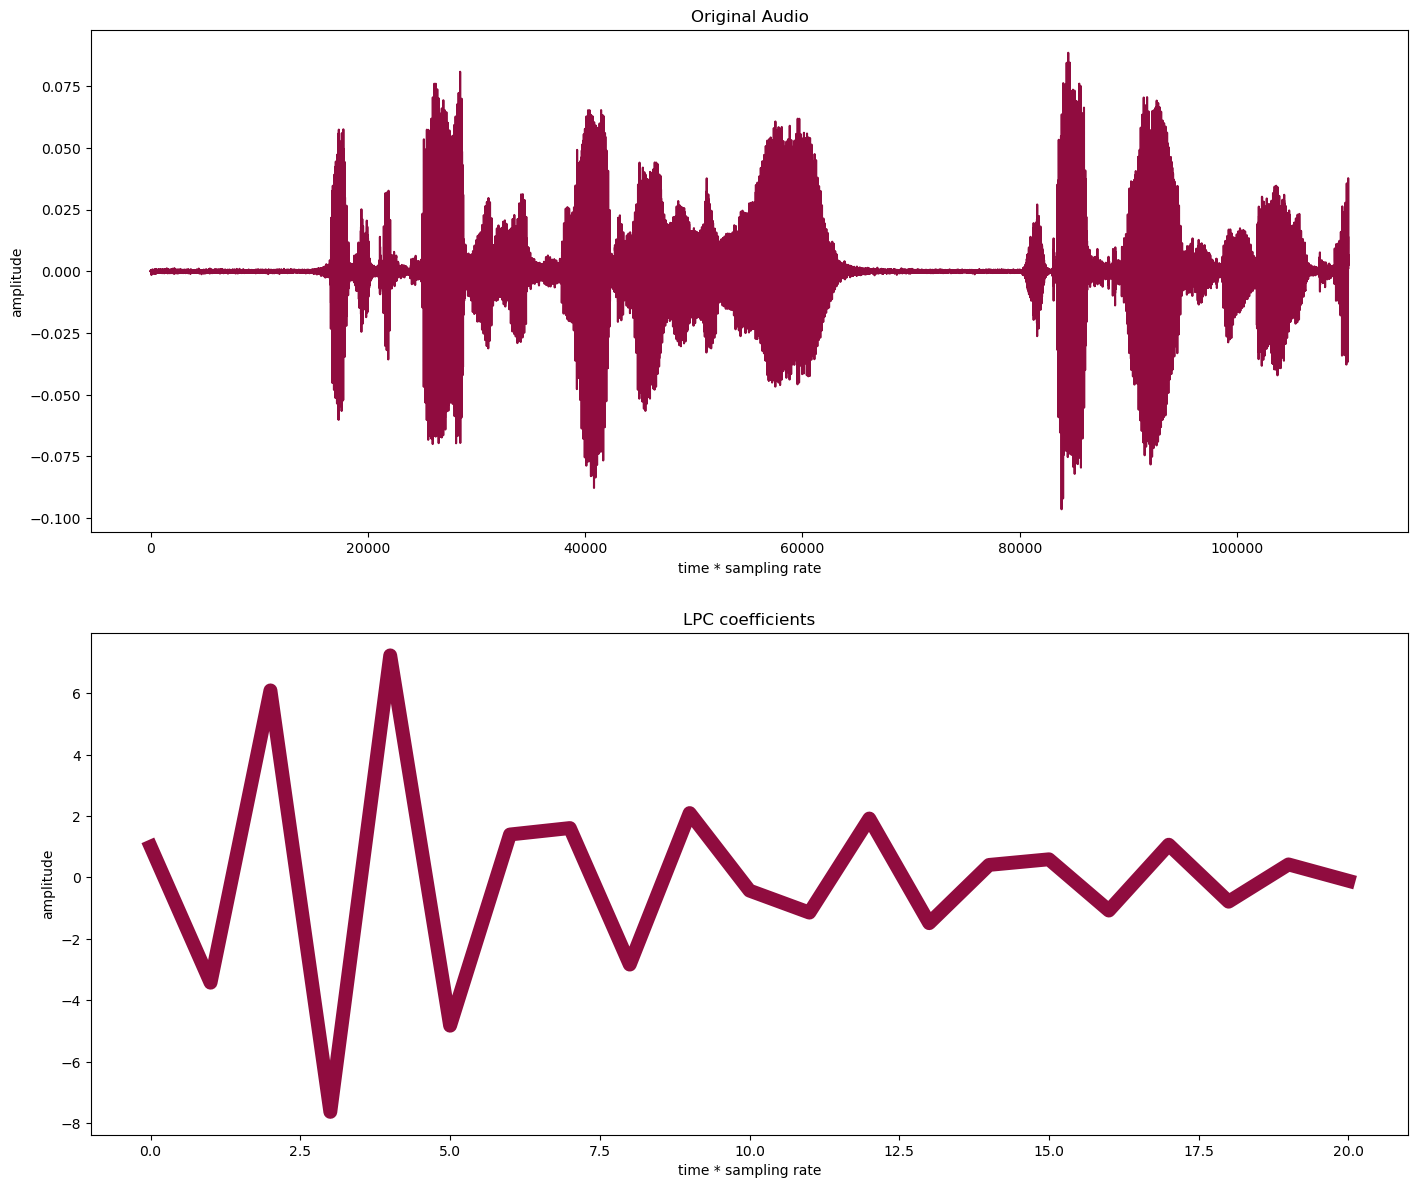

In [37]:
y,sr=librosa.load('_Soundfiles_For_Visualization/Fake_Biden_Dwarf_Fortress10.wav')
plt.figure(figsize=(17, 30))
plt.subplot(4,1,1)
xmin=0
fig_1=plt.plot(y,'#900C3F')
plt.title('Original Audio')
plt.xlabel('time * sampling rate')
plt.ylabel('amplitude') 

plt.subplot(4,1,2)
sample_LPC=levinson_durbin(y,20)
xmin=0
fig_1=plt.plot(sample_LPC,'#900C3F',linewidth=10)
plt.title('LPC coefficients')
plt.xlabel('time * sampling rate')
plt.ylabel('amplitude') 

### Merging all samples to one DataFrame

In [38]:
df3 = pd.concat([realTrumpDF, fakeTrumpDF,realBidenDF,fakeBidenDF], axis=0)
df3.columns = df3.columns.astype(str)
df3

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,real
0,1.0,-1.462473,0.564645,-0.166819,0.234078,-0.105471,0.243328,-0.553614,0.454642,-0.146754,...,0.231442,-0.202941,0.263407,-0.186880,0.154396,-0.295878,0.308526,-0.098418,0.026037,1
1,1.0,-1.335289,0.637207,-0.411074,0.286781,-0.029602,0.161807,-0.487194,0.508751,-0.421582,...,0.212096,-0.222030,0.308872,-0.242193,0.189869,-0.318549,0.323873,-0.125873,0.085432,1
2,1.0,-1.298426,0.545944,-0.293049,0.026858,0.170927,0.233215,-0.579267,0.490646,-0.364439,...,0.176873,-0.221604,0.210013,-0.121898,0.218999,-0.335605,0.205401,-0.137406,0.139650,1
3,1.0,-1.277805,0.417884,-0.181073,0.151802,-0.116040,0.375725,-0.559026,0.439860,-0.221425,...,0.235063,-0.205174,0.233446,-0.129725,0.105741,-0.261151,0.246371,-0.065548,0.047791,1
4,1.0,-1.493168,0.612596,-0.172794,0.258212,-0.125539,0.186235,-0.540897,0.621859,-0.441695,...,0.205414,-0.163679,0.280441,-0.302139,0.185387,-0.236496,0.293452,-0.079608,-0.009681,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,1.0,-3.261176,5.708996,-7.314173,7.244953,-5.246054,2.140653,0.823630,-2.322017,2.031852,...,1.148236,-0.894716,0.228570,0.320564,-0.521987,0.428070,-0.254353,0.131522,-0.025992,3
134,1.0,-3.507110,6.565544,-8.841901,9.258097,-7.532065,4.546927,-1.634244,0.090085,-0.288933,...,3.024818,-2.602541,1.781213,-1.008346,0.460106,-0.121538,-0.070469,0.118512,-0.041083,3
135,1.0,-3.325058,5.670739,-6.801020,6.268592,-4.208217,1.582952,0.440456,-1.021135,0.330038,...,0.995290,-0.514520,0.036115,0.080742,0.026991,-0.084685,0.028327,0.046605,-0.023117,3
136,1.0,-3.202941,5.528640,-6.890757,6.656241,-4.841817,2.314102,-0.108450,-0.916024,0.697237,...,1.065331,-0.865688,0.563119,-0.413101,0.371403,-0.292934,0.161450,-0.051937,0.033579,3


## 2. Analyzing samples

### Logistic regression:

In [39]:
# creating test and train data
X=df3.drop('real',axis=1)
X=sm.tools.add_constant(X)
y=df3['real']
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)

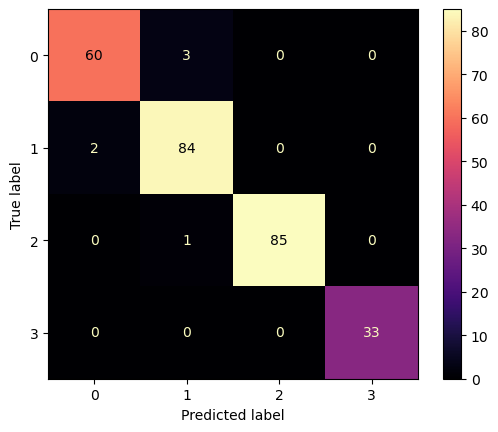

In [40]:
# setting up pipeline
numeric_columns=X.columns.tolist()
numeric_pipeline=Pipeline([('numscaler',MinMaxScaler())])
ct=ColumnTransformer([('numpipe',numeric_pipeline,numeric_columns)])
log_pipe=Pipeline([('preprocess',ct),
                   ('model',LogisticRegression(multi_class='auto',
                                               solver='newton-cg',
                                               C=10**6))])
# fitting and predicting
log_pipe.fit(X_train,y_train)
y_pred = log_pipe.predict(X_test)
y_pred_prob=log_pipe.predict_proba(X_test)
# creating and displaying confusion matrix
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp=disp.plot(include_values=True, cmap='magma', ax=None, 
               xticks_rotation='horizontal')
plt.grid(False)
plt.show()

In [41]:
# creating and displaying classification report
clf_report=classification_report(y_test,y_pred,output_dict=True)
print(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))
pd.DataFrame(clf_report)

0.9978834968837805


,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.967742,0.954545,1.000000,1.0,0.977612,0.980572,0.977831
recall,0.952381,0.976744,0.988372,1.0,0.977612,0.979374,0.977612
f1-score,0.960000,0.965517,0.994152,1.0,0.977612,0.979917,0.977655
support,63.000000,86.000000,86.000000,33.0,0.977612,268.000000,268.000000


### K-nearest neighbors:

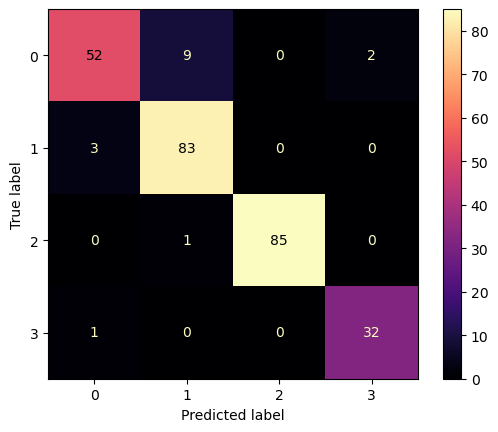

In [42]:
# setting up pipeline
numeric_columns=X.columns.tolist()
numeric_pipeline=Pipeline([('numscaler',MinMaxScaler())])
ct=ColumnTransformer([('numpipe',numeric_pipeline,numeric_columns)])
knn_pipe=Pipeline([('preprocess',ct),
                   ('model',KNeighborsClassifier())])
# setting up gridsearch 
grid_params = {'model__n_neighbors': [3, 5, 7, 9, 11, 15],
               'model__weights': ['uniform', 'distance'],
               'model__metric': ['euclidean', 'manhattan']}
grid = GridSearchCV(estimator=knn_pipe, param_grid=grid_params, 
                    cv=5, n_jobs=-1)
# fitting and predicting
grid.fit(X_train, y_train)
y_pred=grid.predict(X_test)
y_pred_prob=grid.predict_proba(X_test)
# creating and displaying confusion matrix
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp=disp.plot(include_values=True, cmap='magma', ax=None, 
               xticks_rotation='horizontal')
plt.grid(False)
plt.show()

In [43]:
# creating and displaying classification report
clf_report=classification_report(y_test,y_pred,output_dict=True)
print(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))
pd.DataFrame(clf_report)

0.9827863210294329


,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.928571,0.892473,1.000000,0.941176,0.940299,0.940555,0.941461
recall,0.825397,0.965116,0.988372,0.969697,0.940299,0.937146,0.940299
f1-score,0.873950,0.927374,0.994152,0.955224,0.940299,0.937675,0.939673
support,63.000000,86.000000,86.000000,33.000000,0.940299,268.000000,268.000000


### Decision tree:

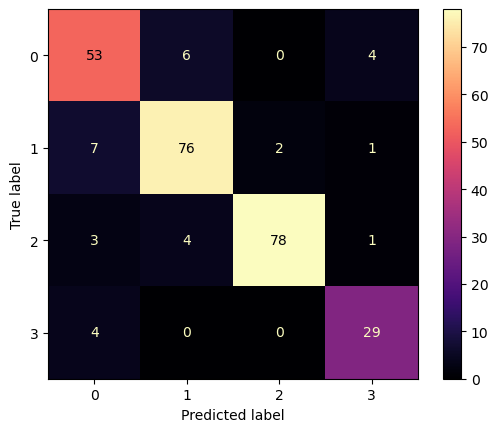

In [44]:
numeric_pipeline=Pipeline([('numscaler',MinMaxScaler())])
ct=ColumnTransformer([('numpipe',numeric_pipeline,numeric_columns)])
tree_pipe=Pipeline([('preprocess',ct),
                    ('tree',DecisionTreeClassifier(criterion = 'gini', random_state=42))])
# fitting and predicting
parameters=dict(tree__criterion=['gini', 'entropy'],
                tree__max_depth = [2,4,6,8,10,12])
grid=GridSearchCV(estimator=tree_pipe,param_grid=parameters,
                 cv=5, n_jobs=-1)
grid.fit(X_train,y_train)
y_pred = grid.predict(X_test)
y_pred_prob=grid.predict_proba(X_test)
# creating and displaying confusion matrix
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp=disp.plot(include_values=True, cmap='magma', ax=None, 
               xticks_rotation='horizontal')
plt.grid(False)
plt.show()

In [45]:
# creating and displaying classification report
clf_report=classification_report(y_test,y_pred,output_dict=True)
print(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))
pd.DataFrame(clf_report)

0.9188745913402266


,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.791045,0.883721,0.975000,0.828571,0.880597,0.869584,0.884435
recall,0.841270,0.883721,0.906977,0.878788,0.880597,0.877689,0.880597
f1-score,0.815385,0.883721,0.939759,0.852941,0.880597,0.872951,0.881849
support,63.000000,86.000000,86.000000,33.000000,0.880597,268.000000,268.000000


# Conclusion
The MLCC approach worked better overall than the LPCC approach.  This is likely due to the fact that MLCCs are a newer invention, presumably more sophisticated, and possibly better suited for this sort of analysis.  

The highest performing model in the MFCC approach was K-nearest, followed by logistic regression and decision tree.  The difference between logistic regression and K-nearest was small.

The highest performing model in the LPCC approach was logistic regression, followed by K-nearest and decision tree.

Decision tree performed significantly worse in both approaches.

# Potential Further Steps
- The audio files sourced for this project contained low to moderate unwanted noise.  If the audio of interest is especially noisy, further processing techniques could be applied before extracting the features.
- All the source audio samples contained one speaker for the entire duration.  It was difficult to find deepfaked audio that only had one speaker - most videos had short clips of multiple speakers, ex.  Obama arguing with Trump, rapidly alternating and each voice segment only lasting a few seconds.  
    - Splitting on silence instead of timeframe would likely allow analysis of these videos.  
- Combining this speaker recognition technique with a neural net for word recognition could yield a audio transcription algorithm. 